In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.constants as const
import astropy.constants as aconst
import random
from time import monotonic
from scipy.optimize import curve_fit
import random

In [2]:
def phi(x,y,z,xp,yp,zp):
    phi_i = 0.0
    for k in range(nbody):
        phi_i += -G*ms/np.sqrt((x-xp[k])**2+(y-yp[k])**2+(z-zp[k])**2+s**2)
    return phi_i

def energy(x,y,z,xp,yp,zp,vx,vy,vz,mi):
    vii = np.sqrt(vx**2+vy**2+vz**2)
    en_pot = phi(x,y,z,xp,yp,zp)*mi
    en_kin = mi*vii**2/2.
    return en_pot, en_kin

def momentum(x,y,z,vx,vy,vz):
    rii = np.sqrt(x**2+y**2+z**2)
    vii = np.sqrt(vx**2+vy**2+vz**2)
    L2 = (rii**2*vii**2*(1-((x*vx+y*vy+z*vz)/(rii*vii))**2)) if (rii*vii) != 0 else 0
    return np.sqrt(L2)

def acc(x,y,z,xp,yp,zp,ds):
    ax = -(phi(x+ds,y,z,xp,yp,zp)-phi(x-ds,y,z,xp,yp,zp))/(2*ds)
    ay = -(phi(x,y+ds,z,xp,yp,zp)-phi(x,y-ds,z,xp,yp,zp))/(2*ds)
    az = -(phi(x,y,z+ds,xp,yp,zp)-phi(x,y,z-ds,xp,yp,zp))/(2*ds)
    return ax, ay, az

def KDK(nsteps,r,v):
    en_pot_j = 0.0
    en_kin_j = 0.0
    mom_j = 0.0
    for j in range(nbody):
        en_pot_j, en_kin_j = energy(r[0][j][0],r[1][j][0],r[2][j][0],r[0,:,0],r[1,:,0],r[2,:,0],v[0][j][0],v[1][j][0],v[2][j][0],mi[j])
        en_pot[0] += en_pot_j
        en_kin[0] += en_kin_j
        mom_j = momentum(r[0][j][0],r[1][j][0],r[2][j][0],v[0][j][0],v[1][j][0],v[2][j][0])
        mom[0] += mom_j
        
        a[0][j][0], a[1][j][0], a[2][j][0] = acc(r[0][j][0],r[1][j][0],r[2][j][0],r[0,:,0],r[1,:,0],r[2,:,0],ds)
    ai[:] = np.sqrt(a[0,:,0]**2+a[1,:,0]**2+a[2,:,0]**2)
    a_max = max(ai)
    dt = np.sqrt(2*eta*epsilon/a_max)
    for i in range(nsteps):
        # kick
        vi = v[:,:,i]+a[:,:,i]*dt/2.
        # drift
        r[:,:,i+1] = r[:,:,i]+vi*dt
        # kick
        for j in range(nbody):
            a[0][j][i+1], a[1][j][i+1], a[2][j][i+1] = acc(r[0][j][i+1],r[1][j][i+1],r[2][j][i+1],r[0,:,i+1],r[1,:,i+1],r[2,:,i+1],ds)
        v[:,:,i+1] = vi+a[:,:,i+1]*dt/2.

        ai[:] = np.sqrt(a[0,:,i+1]**2+a[1,:,i+1]**2+a[2,:,i+1]**2)
        a_max = max(ai)
        dt = np.sqrt(2*eta*epsilon/a_max)
        t[i+1] = t[i]+dt
        
        for j in range(nbody):
            en_pot_j, en_kin_j = energy(r[0][j][i+1],r[1][j][i+1],r[2][j][i+1],r[0,:,i+1],r[1,:,i+1],r[2,:,i+1],v[0][j][i+1],v[1][j][i+1],v[2][j][i+1],mi[j])
            en_pot[i+1] += en_pot_j
            en_kin[i+1] += en_kin_j
            mom_j = momentum(r[0][j][i+1],r[1][j][i+1],r[2][j][i+1],v[0][j][i+1],v[1][j][i+1],v[2][j][i+1])
            mom[i+1] += mom_j
            
    return t, r, v, en_pot, en_kin, mom

In [3]:
params = {'font.size': 16,
          'figure.figsize': (12.,8.),
          'axes.labelsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16
         }
plt.rcParams.update(params)

# Randomowe położenia, zerowe prędkości

In [4]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 0.

time = 1e+4
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01


dim = 3
nbody = 100
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nbody,nsteps+1))
v = np.zeros((dim,nbody,nsteps+1))
a = np.zeros((dim,nbody,nsteps+1))
vi = np.zeros((dim,nbody))
ai = np.zeros(nbody)
mi = np.zeros(nbody)

mi[:] = 1e+11
ms = sum(mi)/nbody

r[0,:,0] = random.choices(range(-2000,2000), k=nbody)
r[1,:,0] = random.choices(range(-2000,2000), k=nbody)
r[2,:,0] = random.choices(range(-2000,2000), k=nbody)

start = monotonic()
t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 1519.8548118830004 s


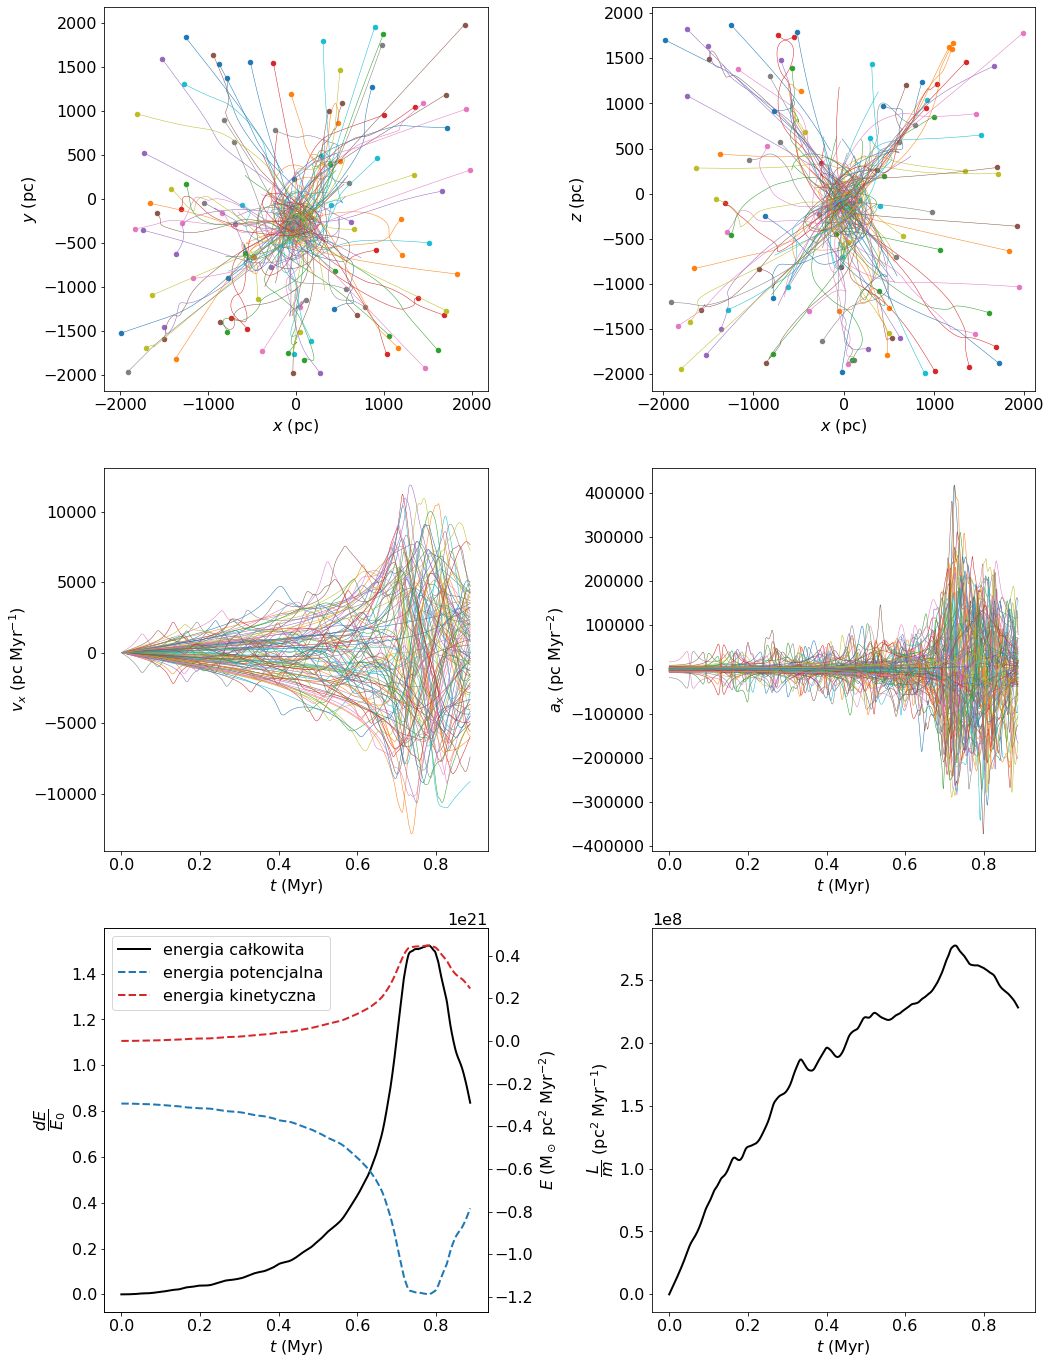

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

for j in range(nbody):
    pl = ax[0,0].scatter(r[0][j][0], r[1][j][0], s=20)
    ax[0,0].plot(r[0][j], r[1][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[0,1].scatter(r[0][j][0], r[2][j][0], s=20, color=pl.get_facecolor()[0])
    ax[0,1].plot(r[0][j], r[2][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[1,0].plot(t, v[0][j], ls='-', lw=0.5)
    ax[1,1].plot(t, a[0][j], ls='-', lw=0.5)

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")

ax2 = ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')

ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")
ax[2,1].plot(t, mom, ls='-', lw=2, c='k')
ax[2,1].set_xlabel(r"$t$ (Myr)")
ax[2,1].set_ylabel(r"$\dfrac{L}{m}$ (pc$^2$ Myr$^{-1}$)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("ss4.png", dpi=300, bbox_inches='tight')

# Randomowe położenia, randomowe prędkości

In [6]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 0

time = 1e+4
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01


dim = 3
nbody = 100
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nbody,nsteps+1))
v = np.zeros((dim,nbody,nsteps+1))
a = np.zeros((dim,nbody,nsteps+1))
vi = np.zeros((dim,nbody))
ai = np.zeros(nbody)
mi = np.zeros(nbody)
R_bar = np.zeros(nbody)
V_bar = np.zeros(nbody)

mi[:] = 1e+11
ms = sum(mi)/nbody

r[0,:,0] = random.choices(range(-2000,2000), k=nbody)
r[1,:,0] = random.choices(range(-2000,2000), k=nbody)
r[2,:,0] = random.choices(range(-2000,2000), k=nbody)

v[0,:,0] = random.choices(range(-200,200), k=nbody)
v[1,:,0] = random.choices(range(-200,200), k=nbody)
v[2,:,0] = random.choices(range(-200,200), k=nbody)

start = monotonic()
t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 1479.2688295740008 s


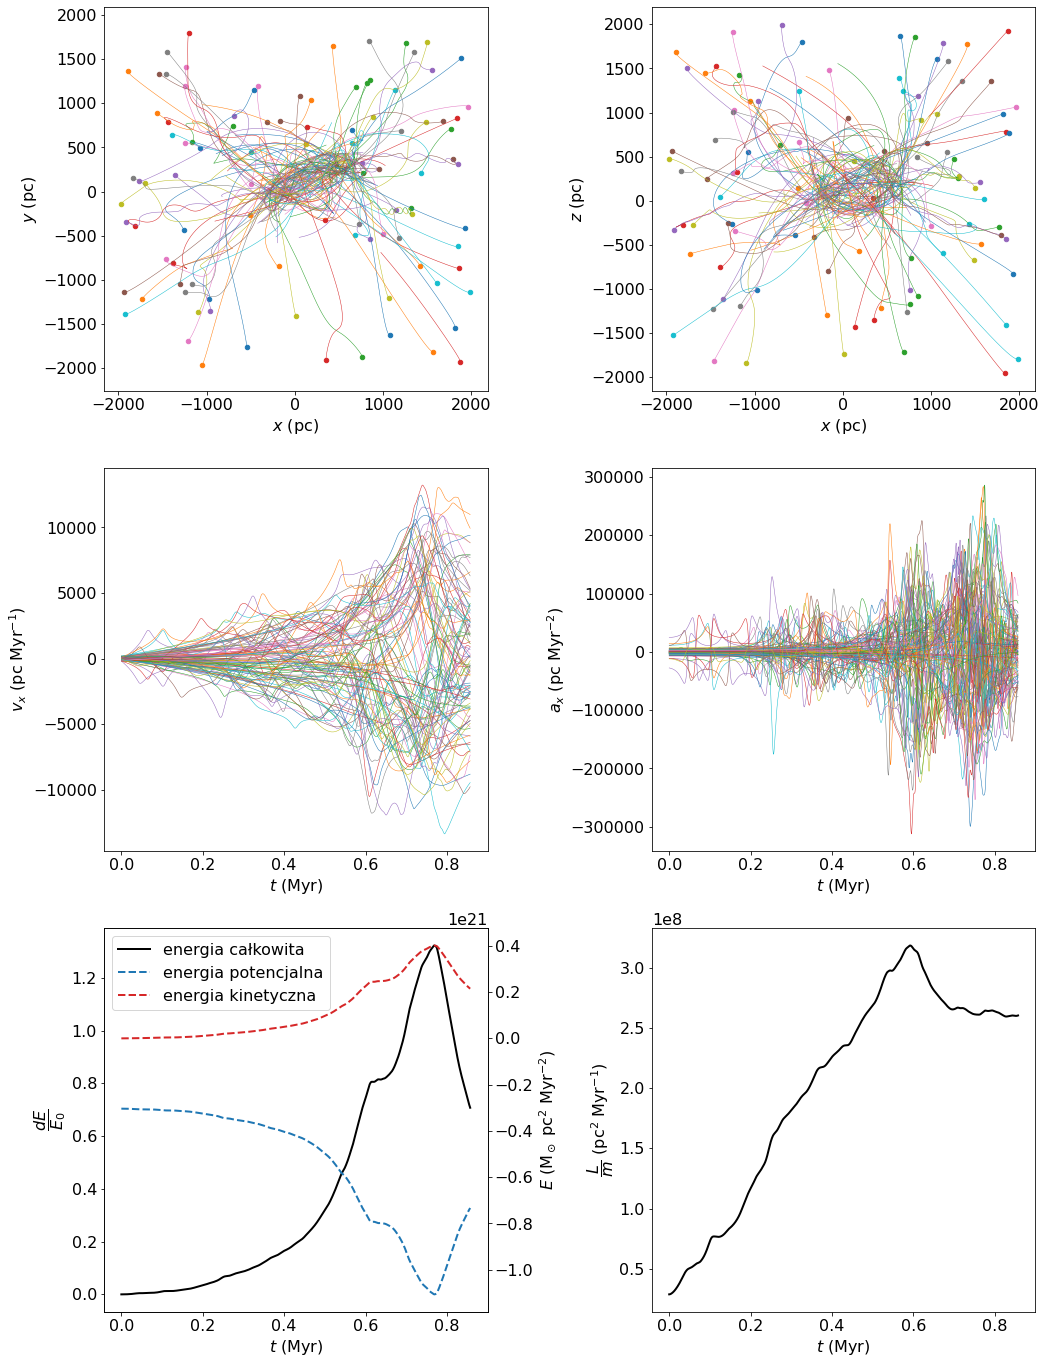

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

for j in range(nbody):
    pl = ax[0,0].scatter(r[0][j][0], r[1][j][0], s=20)
    ax[0,0].plot(r[0][j], r[1][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[0,1].scatter(r[0][j][0], r[2][j][0], s=20, color=pl.get_facecolor()[0])
    ax[0,1].plot(r[0][j], r[2][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[1,0].plot(t, v[0][j], ls='-', lw=0.5)
    ax[1,1].plot(t, a[0][j], ls='-', lw=0.5)

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")

ax2 = ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')

ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")
ax[2,1].plot(t, mom, ls='-', lw=2, c='k')
ax[2,1].set_xlabel(r"$t$ (Myr)")
ax[2,1].set_ylabel(r"$\dfrac{L}{m}$ (pc$^2$ Myr$^{-1}$)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("lp4.png", dpi=300, bbox_inches='tight')

# Randomowe położenia 2D, prędkości kołowe

In [8]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 0.

time = 5e+4
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01


dim = 3
nbody = 100
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nbody,nsteps+1))
v = np.zeros((dim,nbody,nsteps+1))
a = np.zeros((dim,nbody,nsteps+1))
vi = np.zeros((dim,nbody))
ai = np.zeros(nbody)
mi = np.zeros(nbody)
R_bar = np.zeros(nbody)
V_bar = np.zeros(nbody)
alpha = np.zeros(nbody)

mi[:] = 1e+11
ms = sum(mi)/nbody

r[0,:,0] = random.choices(range(-2000,2000), k=nbody)
r[1,:,0] = random.choices(range(-2000,2000), k=nbody)

for i in range(nbody):
    m = 0.
    alpha[i] = np.arctan2(r[1,i,0], r[0,i,0])
    for j in range(nbody):
        if np.sqrt(r[0,j,0]**2+r[1,j,0]**2+r[2,j,0]**2) < np.sqrt(r[0,i,0]**2+r[1,i,0]**2+r[2,i,0]**2):
            m += 1
    v[0,i,0] = -np.sqrt(G*m*mi[i]/(np.sqrt(r[0,i,0]**2+r[1,i,0]**2+r[2,i,0]**2)))*np.sin(alpha[i])
    v[1,i,0] = np.sqrt(G*m*mi[i]/(np.sqrt(r[0,i,0]**2+r[1,i,0]**2+r[2,i,0]**2)))*np.cos(alpha[i])

start = monotonic()
t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 7379.963105126 s


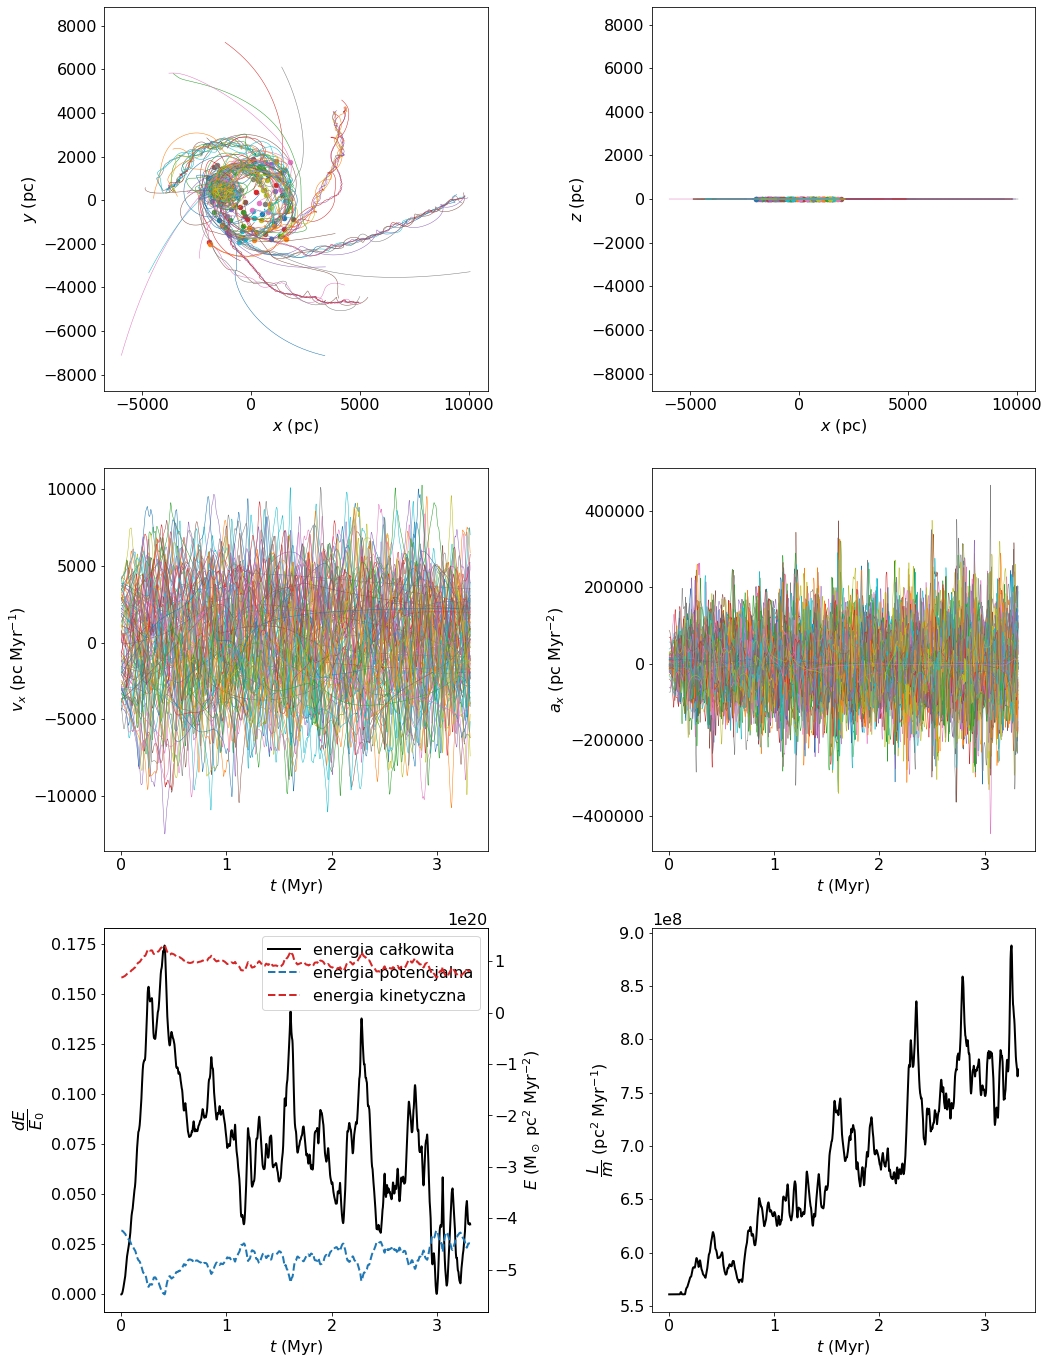

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

for j in range(nbody):
    pl = ax[0,0].scatter(r[0][j][0], r[1][j][0], s=20)
    ax[0,0].plot(r[0][j], r[1][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[0,1].scatter(r[0][j][0], r[2][j][0], s=20, color=pl.get_facecolor()[0])
    ax[0,1].plot(r[0][j], r[2][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[1,0].plot(t, v[0][j], ls='-', lw=0.5)
    ax[1,1].plot(t, a[0][j], ls='-', lw=0.5)

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")

ax2 = ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')

ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")
ax[2,1].plot(t, mom, ls='-', lw=2, c='k')
ax[2,1].set_xlabel(r"$t$ (Myr)")
ax[2,1].set_ylabel(r"$\dfrac{L}{m}$ (pc$^2$ Myr$^{-1}$)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("ok4.png", dpi=300, bbox_inches='tight')

# Randomowe położenia 2D, prędkości kołowe + niewielkie zaburzenie

In [10]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 0.

time = 5e+4
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01


dim = 3
nbody = 100
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nbody,nsteps+1))
v = np.zeros((dim,nbody,nsteps+1))
a = np.zeros((dim,nbody,nsteps+1))
vi = np.zeros((dim,nbody))
ai = np.zeros(nbody)
mi = np.zeros(nbody)
R_bar = np.zeros(nbody)
V_bar = np.zeros(nbody)
alpha = np.zeros(nbody)

mi[:] = 1e+11
ms = sum(mi)/nbody

r[0,:,0] = random.choices(range(-2000,2000), k=nbody)
r[1,:,0] = random.choices(range(-2000,2000), k=nbody)

for i in range(nbody):
    m = 0.
    alpha[i] = np.arctan2(r[1,i,0], r[0,i,0])
    for j in range(nbody):
        if np.sqrt(r[0,j,0]**2+r[1,j,0]**2+r[2,j,0]**2) < np.sqrt(r[0,i,0]**2+r[1,i,0]**2+r[2,i,0]**2):
            m += 1
    v[0,i,0] = -np.sqrt(G*m*mi[i]/(np.sqrt(r[0,i,0]**2+r[1,i,0]**2+r[2,i,0]**2)))*np.sin(alpha[i])+random.choices(range(-50,50), k=1)[0]
    v[1,i,0] = np.sqrt(G*m*mi[i]/(np.sqrt(r[0,i,0]**2+r[1,i,0]**2+r[2,i,0]**2)))*np.cos(alpha[i])+random.choices(range(-50,50), k=1)[0]

start = monotonic()
t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 7390.155512450998 s


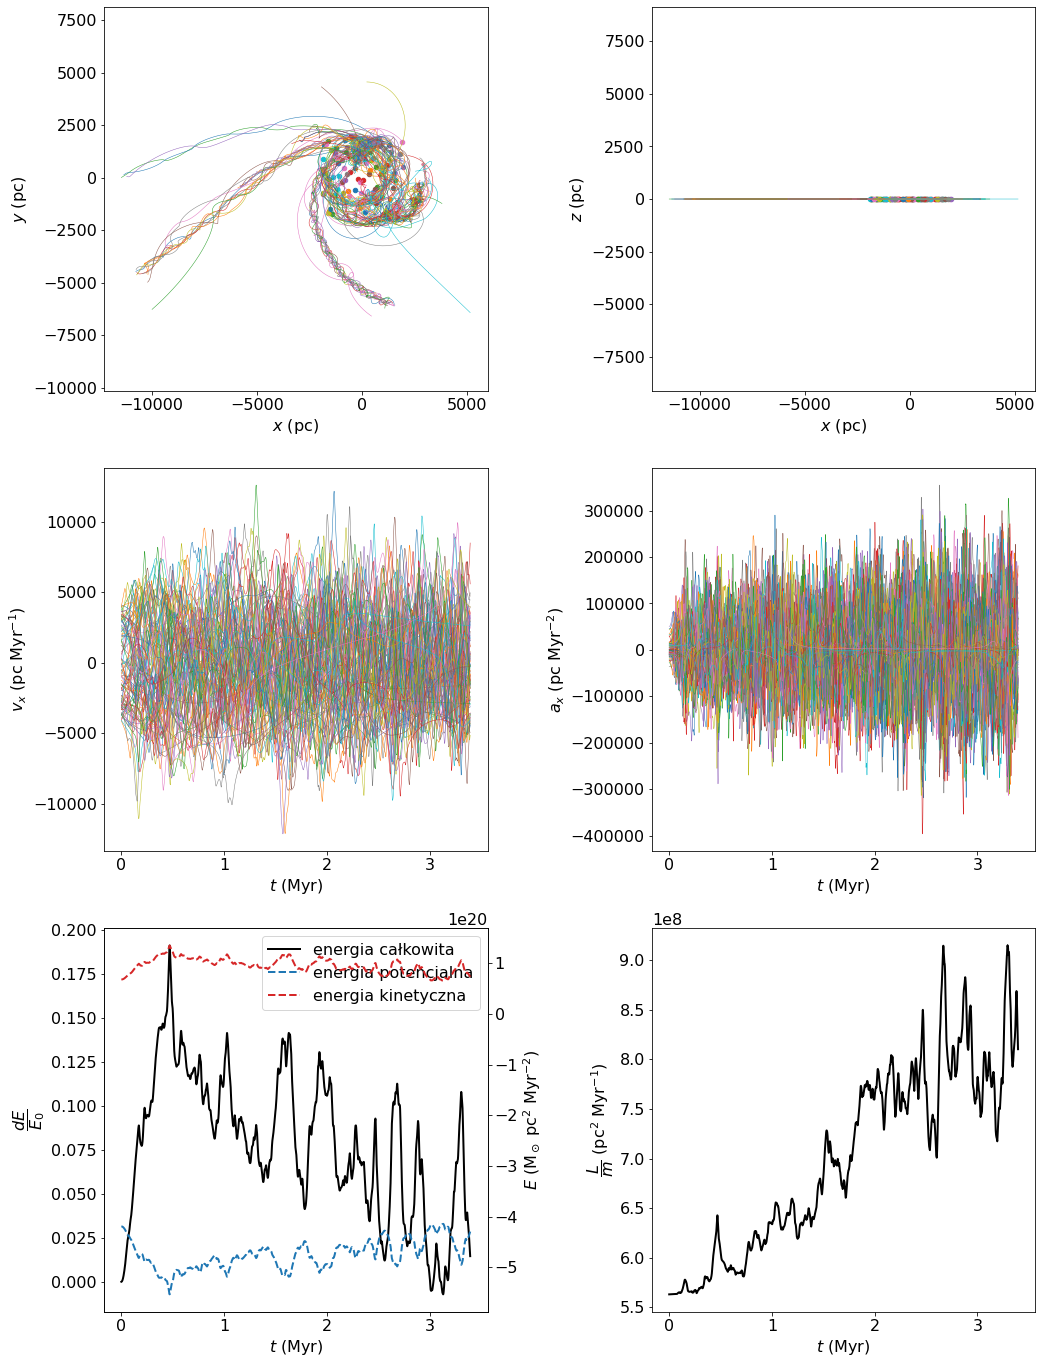

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

for j in range(nbody):
    pl = ax[0,0].scatter(r[0][j][0], r[1][j][0], s=20)
    ax[0,0].plot(r[0][j], r[1][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[0,1].scatter(r[0][j][0], r[2][j][0], s=20, color=pl.get_facecolor()[0])
    ax[0,1].plot(r[0][j], r[2][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[1,0].plot(t, v[0][j], ls='-', lw=0.5)
    ax[1,1].plot(t, a[0][j], ls='-', lw=0.5)

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")

ax2 = ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')

ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")
ax[2,1].plot(t, mom, ls='-', lw=2, c='k')
ax[2,1].set_xlabel(r"$t$ (Myr)")
ax[2,1].set_ylabel(r"$\dfrac{L}{m}$ (pc$^2$ Myr$^{-1}$)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("okz4.png", dpi=300, bbox_inches='tight')

# Czas obliczeń vs. liczba symulowanych cząstek

In [12]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 0.

time = 1e+4
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01

dim = 3

t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)

nbody_list = [3, 5, 8, 10, 15, 20, 25, 30, 50, 100]

N = []
t_cpu = []

for i in nbody_list:
    dt = 1 # Myr
    nbody = i
    r = np.zeros((dim,nbody,nsteps+1))
    v = np.zeros((dim,nbody,nsteps+1))
    a = np.zeros((dim,nbody,nsteps+1))
    vi = np.zeros((dim,nbody))
    ai = np.zeros(nbody)
    mi = np.zeros(nbody)
    mi[:] = 1e+11
    ms = sum(mi)/nbody

    r[0,:,0] = random.choices(range(-3000,3000), k=nbody)
    r[1,:,0] = random.choices(range(-3000,3000), k=nbody)
    r[2,:,0] = random.choices(range(-3000,3000), k=nbody)

    start = monotonic()
    t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
    end = monotonic()
    
    N.append(nbody)
    t_cpu.append(end-start)

Parametry dopasowania
a = 0.1658824478853788
b = 1.9729785723047681


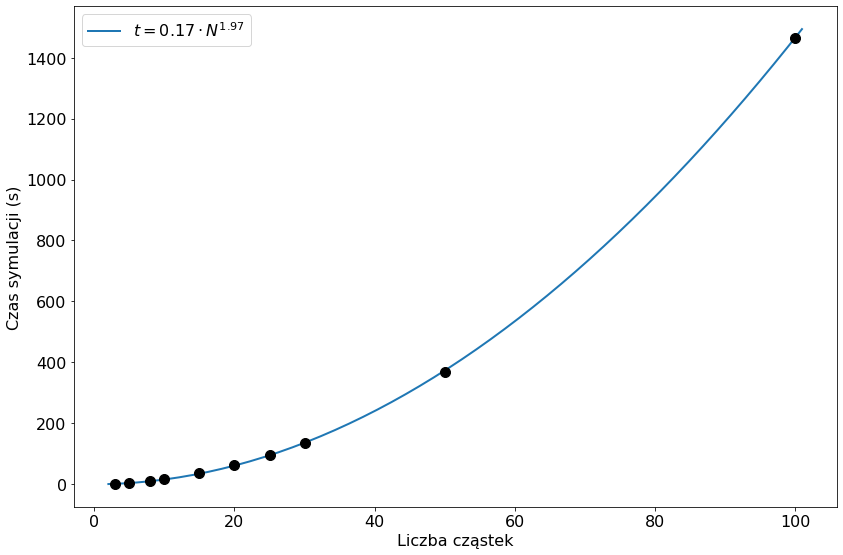

In [13]:
def fun(N, a, b):
    return a*N**b

popt, pcov = curve_fit(fun, N, t_cpu)
print("Parametry dopasowania")
print(f"a = {popt[0]}")
print(f"b = {popt[1]}")

plt.figure(10, tight_layout=True)

plt.scatter(N, t_cpu, c='k', s=100, zorder=10)
x = np.linspace(2,101)
plt.plot(x, fun(x, *popt), lw=2, c='tab:blue', label=f"$t={round(popt[0],2)} \cdot N^{{{round(popt[1],2)}}}$")

plt.xlabel("Liczba cząstek")
plt.ylabel("Czas symulacji (s)")
plt.legend()

plt.savefig("N_vs_tcpu.pdf", bbox_inches='tight')